In [24]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
import seaborn as sns
import pandas as pd

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = ""
exts = [".png", ".svg"]

bmb_green = "#009800ff"
bmb_magenta = "#fe36d0ff"

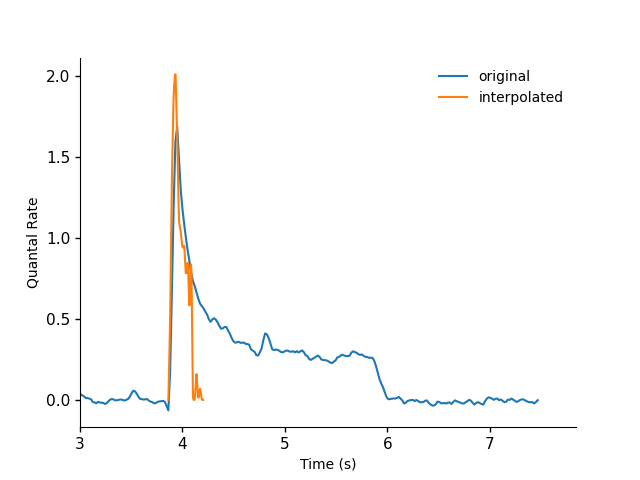

In [4]:
quanta_h5 = "quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
target_rate_dt = 0.005  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)

trans_rise = find_rise_bsln(bp_inputs["trans"], bsln_start=100, bsln_end=150, step=1) * rec_dt
rate_fig, rate_ax = plt.subplots(1)
rate_ax.plot(np.arange(len(bp_inputs["trans"])) * rec_dt, bp_inputs["trans"], label="original")
rate_ax.plot(np.arange(len(vrate)) * target_rate_dt + trans_rise, vrate, label="interpolated")
rate_ax.set_xlim(3)
rate_ax.set_xlabel("Time (s)")
rate_ax.set_ylabel("Quantal Rate")
rate_ax.legend(frameon=False)
clean_axes(rate_ax)

In [5]:
model_path = os.path.join(base_path, "param_runs")
fig_dir_path = os.path.join(model_path, "figs") 
overwrite = False

save_name = "test"

load_name = None

model_config = configs.thesis(
    ttx=False,
    non_ds_ach=False,
    offset_ampa_ach=False,
    record_tree=False,
    poisson_rates={"sac": vrate / np.max(vrate), "glut": vrate / np.max(vrate), "dt": target_rate_dt},
    plexus=0,
    plexus_share=None,
    stacked_plex=False,
)

n_nets = 9
n_trials = 5
rho_steps = [0.0, 1.0]
pool_sz = 6

param_paths = [
    ["synprops", "E", "pref_prob"], 
    ["synprops", "PLEX", "pref_prob"],
    ["synprops", "I", "pref_prob"], 
    ["synprops", "AMPA", "pref_prob"], 
    ["synprops", "AMPA", "null_prob"], 
    ["synprops", "NMDA", "pref_prob"], 
    ["synprops", "NMDA", "null_prob"], 
]

ratio_steps = [1, 1 / 1.333, 1 / 1.45, 0.5]
ach_steps = ratio_steps
ampa_steps = list((1 - np.array(ratio_steps)) / 2)
gaba_steps = [1, 1, 1, 1]
nmda_steps = [1, 1, 1, 1]

param_steps = [
    ach_steps,
    ach_steps,
    gaba_steps,
    ampa_steps,
    ampa_steps,
    nmda_steps,
    nmda_steps,
]
# step_lbls = [1.0, 2.5, 3.0]
step_lbls = list(np.array(ach_steps).round(decimals=2))
step_lbls = list(np.array(ratio_steps).round(decimals=2))

save_path = os.path.join(model_path, save_name) + ".h5"
if load_name is None:
    load_name = save_name
    if (not overwrite and os.path.exists(save_path)):
        print(
            "Loading %s rather than overwriting it.\nSet `overwrite = True` if saving over is desired."
            % save_name
        )
    else:
        from ei_balance_nogui import *
        os.makedirs(model_path, exist_ok=True)
        save_path = os.path.join(model_path, save_name) + ".h5"
        load_name = save_name
        t0 = time.time()
        exps.sacnet_param_run(
            save_path,
            model_config,
            param_paths,
            param_steps,
            step_lbls,
            n_nets=n_nets,
            n_trials=n_trials,
            rho_steps=rho_steps,
            pool_sz=pool_sz,
            reset_seed_between_rho=True,
        )
            
        print("parameter run time:", time.time() - t0)

hdf = h5.File(os.path.join(model_path, load_name) + ".h5", "r")
d = Workspace(hdf, read_only=True)
fig_path = os.path.join(fig_dir_path, load_name)
os.makedirs(fig_path, exist_ok=True)

param_paths = [d["run_params"]["paths"][i][:] for i in d["run_params"]["paths"].keys()]
param_steps = [d["run_params"]["steps"][i][:] for i in d["run_params"]["steps"].keys()]
step_lbls = d["run_params"]["step_lbls"][:]
n_steps = len(step_lbls)
step_idxs = list(range(n_steps))
rhos = list(d[step_lbls[0]].keys())
idxs = list(d[step_lbls[0]][rhos[0]].keys())
print("==keys==")
print("step_idxs:", step_idxs)
print("step_lbls:", step_lbls)
print("rhos:", rhos)
print("idxs:", idxs)

Loading locked_total_e_slow_ampa rather than overwriting it.
Set `overwrite = True` if saving over is desired.
==keys==
step_idxs: [0, 1, 2, 3]
step_lbls: [1.   0.75 0.69 0.5 ]
rhos: [0.0, 1.0]
idxs: [0, 1, 2, 3, 4, 5, 6, 7, 8]


In [6]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            d.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [27]:
metrics = {k: ana.get_sac_metrics(d[k]) for k in step_lbls}

dir_labels = d[step_lbls[0]][rhos[0]][idxs[0]]["params"]["dir_labels"][:]
null_idx = np.argwhere(dir_labels == 180)[0][0]
pref_idx = np.argwhere(dir_labels == 0)[0][0]
sac_thetas = ana.get_sac_thetas(d[step_lbls[0]])
sac_deltas = ana.get_sac_deltas(sac_thetas)

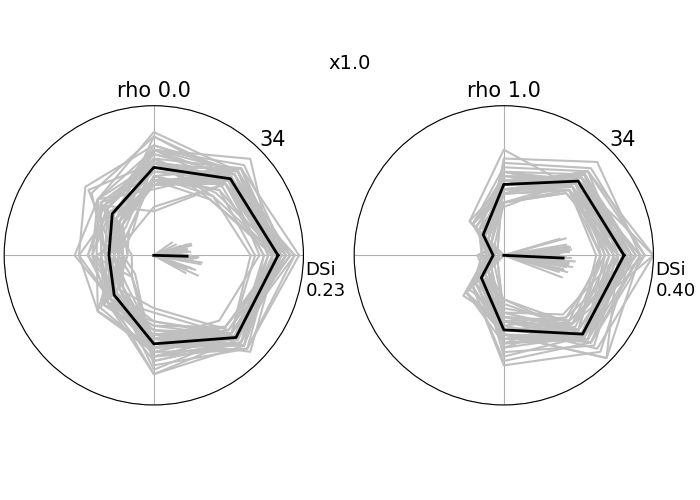

In [8]:
step_lbl = step_lbls[0]
max_spikes = np.max([r["spikes"] for r in metrics[step_lbl].values()])
focus_polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(rhos)
focus_polar_ax = [
    polar_plot(
        m,
        dir_labels,
        title="rho " + str(r),
        radius=max_spikes,
        # radius=50,
        net_shadows=False,
        save=False,
        fig=focus_polar_fig,
        sub_loc=(1, n_cols, loc + 1),
        title_metrics=False,
    )
    for loc, (r, m) in enumerate(metrics[step_lbl].items())
]
focus_polar_fig.suptitle("x%.1f" % (step_lbl), fontsize=14)
focus_polar_fig.set_layout_engine("compressed")
for ext in [".png", ".svg"]:
    focus_polar_fig.savefig(
        os.path.join(fig_path, "contrast_x%.1f_polars%s" % (step_lbl, ext)), bbox_inches="tight")

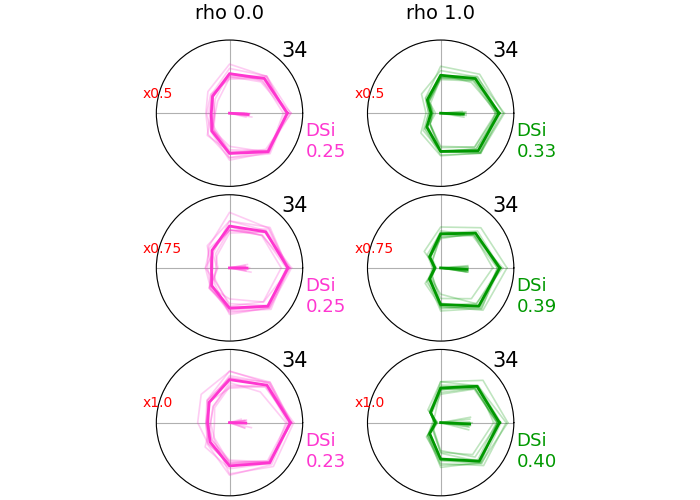

In [9]:
display_steps = step_lbls
# display_steps = [1.0, 0.75, 0.5]
display_steps = [0.5, 0.75, 1.0]

colours = ["red", "black"]
colours = [bmb_magenta, bmb_green]

max_spikes = np.max([r["spikes"] for s in display_steps for r in metrics[s].values()])
polar_fig = plt.figure(figsize=(7, 5))
max_rows = 5
n_rows = min(max_rows, len(display_steps))
splits = int(np.ceil(len(display_steps) / max_rows))
n_cols = len(rhos) * splits
polar_ax = []
for i, factor in enumerate(display_steps):
    row = i % max_rows
    subcol = i // max_rows
    for j, (rho, m) in enumerate(metrics[factor].items()):
        polar_ax.append(polar(
            m["spikes"],
            dir_labels,
            title=None,
            title_metrics=False,
            radius=max_spikes,
            net_shadows=True,
            fig=polar_fig,
            sub_loc=(n_rows, n_cols, (row * n_cols + j * splits + subcol + 1)),
            dsi_tag_deg=-30,
            dsi_tag_mult=1.2,
            avg_colour=colours[j],
            shadow_alpha=0.25,
            shadow_linewidth=1.2,
        ))
        polar_ax[-1].text(np.radians(170), max_spikes * 1.2, ("x" + str(factor)), c="red")

for i in range(len(rhos)):
    polar_ax[i].set_title("rho %.1f" % rhos[i], fontsize=14, pad=15)

polar_fig.set_layout_engine("compressed")

lbl = "many" if len(display_steps) > 4 else "_".join(map(str, display_steps)).replace(".", "p")
for ext in [".png", ".svg"]:
    polar_fig.savefig(
        os.path.join(fig_path, "polar_grid_contrast_%s%s" % (lbl, ext)), bbox_inches="tight")

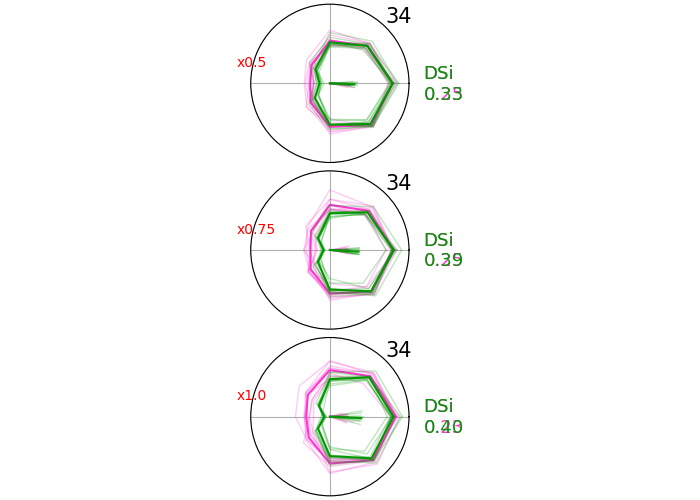

In [42]:
display_rhos = rhos
display_steps = step_lbls
display_steps = [0.5, 0.75, 1.0]

if len(display_rhos) <= 2:
    colours = ["black", "red"]
    colours = [bmb_magenta, bmb_green] 
else:
    colours = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8"]
    
max_spikes = np.max([r["spikes"] for s in display_steps for r in metrics[s].values()])
    
polar_overlay_fig = plt.figure(figsize=(7, 5))
max_rows = 5
n_rows = min(max_rows, len(display_steps))
splits = int(np.ceil(len(display_steps) / max_rows))
n_cols = splits
polar_overlay_ax = []
for i, step in enumerate(display_steps):
    row = i % max_rows
    subcol = i // max_rows
    sub_loc = (n_rows, n_cols, (row * n_cols + subcol + 1))
    ax = polar_overlay_fig.add_subplot(*sub_loc, projection="polar")
    for k, rho in enumerate(display_rhos): 
        polar(
            metrics[step][rho]["spikes"],
            dir_labels,
            title=None,
            title_metrics=False,
            radius=max_spikes,
            net_shadows=True,
            ax=ax,
            dsi_tag_deg=-30,
            dsi_tag_mult=1.2,
            avg_colour=colours[k],
            avg_linewidth=1.5,
            shadow_alpha=0.25,
            # shadow_linewidth=1.2,
            shadow_linewidth=1,
        )
    polar_overlay_ax.append(ax)
    polar_overlay_ax[-1].text(np.radians(170), max_spikes * 1.2, ("x" + str(step)), c="red")

# for i, exp in enumerate(display_exps):
#     polar_overlay_ax[i * splits].set_title(exp, fontsize=14, pad=15)

polar_overlay_fig.set_layout_engine("compressed")
rhos_lbl = "many_rhos" if len(display_rhos) > 4 else ("rhos" + "_".join(map(str, display_rhos)).replace(".", "p"))
steps = "many_steps" if len(display_steps) > 4 else "_".join(map(str, display_steps)).replace(".", "p")
for ext in exts:
    polar_overlay_fig.savefig(
        os.path.join(fig_path, "polar_overlay_grid_%s_%s%s" % (
            rhos_lbl, steps, ext)),
        bbox_inches="tight"
    )

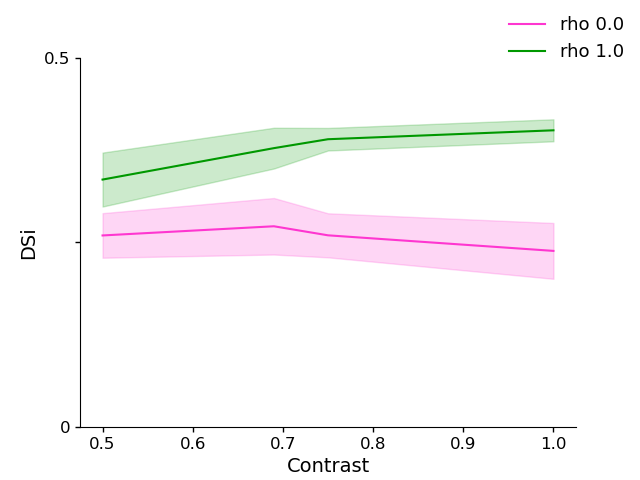

In [10]:
# TODO, swarm boxplots would be better for the AMPA experiment (only a few levels)
colours = [bmb_magenta, bmb_green]

dsi_fig, dsi_ax = plt.subplots(1)
titration_dsis = {}
for i, rho in enumerate(rhos):
    titration_dsis[rho] = {"nets": [], "avg": [], "std": []}
    for step_lbl in step_lbls:
        dsis = metrics[step_lbl][rho]["DSis"]
        dsi_net_avgs = metrics[step_lbl][rho]["DSis"].mean(axis=1)
        titration_dsis[rho]["nets"].append(dsi_net_avgs)
        titration_dsis[rho]["avg"].append(np.mean(dsi_net_avgs))
        titration_dsis[rho]["std"].append(np.std(dsi_net_avgs))
    titration_dsis[rho] = {m: np.array(v) for m, v in titration_dsis[rho].items()}
    titration_dsis[rho]["nets"] = titration_dsis[rho]["nets"].T
    dsi_ax.fill_between(
        step_lbls, 
        titration_dsis[rho]["avg"] + titration_dsis[rho]["std"],
        titration_dsis[rho]["avg"] - titration_dsis[rho]["std"],
        alpha=0.2,
        color=colours[i],
    )
    dsi_ax.plot(step_lbls, titration_dsis[rho]["avg"], c=colours[i], label="rho " + str(rho))
        
dsi_ax.set_ylabel("DSi", fontsize=14)
dsi_ax.set_xlabel("Contrast", fontsize=14)
# dsi_ax.set_xscale("log")
# dsi_ax.set_ylim(0, 0.4)
# dsi_ax.set_yticks([0, 0.2, 0.4])
dsi_ax.set_ylim(0, 0.5)
dsi_ax.set_yticks([0, 0.25, 0.5])
dsi_ax.set_yticklabels([0, None, 0.5])

dsi_fig.legend(frameon=False, fontsize=13)
clean_axes(dsi_ax, ticksize=12)
for ext in [".png", ".svg"]:
    dsi_fig.savefig(os.path.join(fig_path, "dsi_vs_contrasts%s" % (ext)), bbox_inches="tight")

/home/geoff/miniconda3/envs/nrn312/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


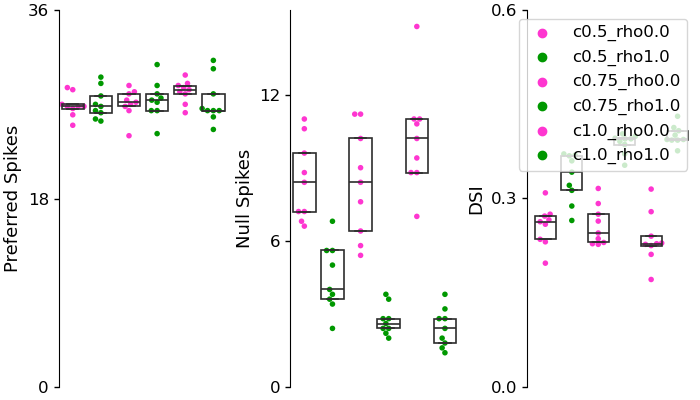

In [35]:
display_rhos = rhos
display_steps = step_lbls
display_steps = [0.5, 0.75, 1.0]

rho = 1.0
factor = 1.0
palette = [bmb_green, bmb_magenta]
# palette = [bmb_green, bmb_magenta, "cyan", "black"]
palette = [bmb_magenta, bmb_green, bmb_magenta, bmb_green, bmb_magenta, bmb_green]
display_tups = [(s, r, "c%s_rho%s" % (str(s), str(r))) for s in display_steps for r in display_rhos]

swarm_kw = dict(palette=palette, size=4, zorder=0.5, alpha=1)
box_kw = dict(palette=palette, linewidth=1.2, whis=0, fliersize=0, boxprops=dict(facecolor='None'))
ds_swarm_fig, ds_swarm_ax = plt.subplots(1, 3, figsize=(7, 4))

pref_df = pd.DataFrame.from_dict({k: np.mean(metrics[s][r]["spikes"][:, :, pref_idx], axis=1) for s, r, k in display_tups})
sns.boxplot(pref_df, ax=ds_swarm_ax[0], **box_kw)
sns.swarmplot(pref_df, ax=ds_swarm_ax[0], **swarm_kw)
ds_swarm_ax[0].set_ylabel("Preferred Spikes", fontsize=13)

null_df = pd.DataFrame.from_dict({k: np.mean(metrics[s][r]["spikes"][:, :, null_idx], axis=1) for s, r, k in display_tups})
sns.boxplot(null_df, ax=ds_swarm_ax[1], **box_kw)
sns.swarmplot(null_df, ax=ds_swarm_ax[1], **swarm_kw)
ds_swarm_ax[1].set_ylabel("Null Spikes", fontsize=13)

dsi_df = pd.DataFrame.from_dict({k: metrics[s][r]["avg_DSi"] for s, r, k in display_tups})
sns.boxplot(dsi_df, ax=ds_swarm_ax[2], **box_kw)
sns.swarmplot(dsi_df, ax=ds_swarm_ax[2], **swarm_kw)
ds_swarm_ax[2].set_ylabel("DSI", fontsize=13)

for tup, c in zip(display_tups, palette):
    ds_swarm_ax[2].scatter([], [], c=c, label=tup[2])
    
pref_ymax = 36
null_ymax = 12
dsi_ymax = 0.6

ds_swarm_ax[0].set_yticks([0, pref_ymax / 2, pref_ymax])
ds_swarm_ax[1].set_yticks([0, null_ymax / 2, null_ymax])
ds_swarm_ax[2].set_yticks([0, dsi_ymax / 2, dsi_ymax])
if 0:
    ds_swarm_ax[0].set_yticklabels([0, None, pref_ymax])
    ds_swarm_ax[1].set_yticklabels([0, None, null_ymax])
    ds_swarm_ax[2].set_yticklabels([0, None, dsi_ymax])


ds_swarm_ax[2].legend(frameon=True, fontsize=12, loc="upper right")
clean_axes(ds_swarm_ax, ticksize=12, remove_spines=["top", "right", "bottom"])
ds_swarm_fig.set_layout_engine("compressed")

steps_lbl = "_".join(map(str, display_steps))
rhos_lbl = "_".join(map(str, display_rhos))
for ext in exts:
    ds_swarm_fig.savefig(
        os.path.join(fig_path, "spikes_and_dsi_swarmplot_steps%s_rho%s%s" % (
            steps_lbl, rhos_lbl, ext)), bbox_inches="tight")

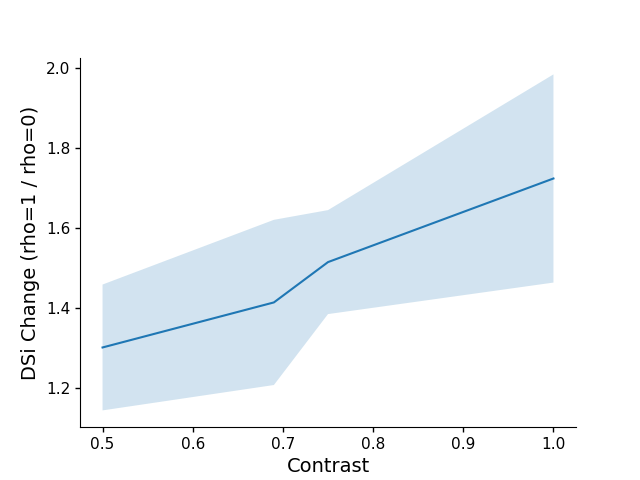

In [11]:
rho_dsi_effect_fig, rho_dsi_effect_ax = plt.subplots(1)
dsi_effect_nets = titration_dsis[1.0]["nets"] / titration_dsis[0.0]["nets"]
dsi_effect_avg = np.mean(dsi_effect_nets, axis=0)
dsi_effect_std = np.std(dsi_effect_nets, axis=0)

rho_dsi_effect_ax.fill_between(
    step_lbls, 
    dsi_effect_avg + dsi_effect_std,
    dsi_effect_avg - dsi_effect_std,
    alpha=0.2
)
rho_dsi_effect_ax.plot(step_lbls, dsi_effect_avg)

rho_dsi_effect_ax.set_ylabel("DSi Change (rho=1 / rho=0)", fontsize=14)
rho_dsi_effect_ax.set_xlabel("Contrast", fontsize=14)
# rho_dsi_effect_ax.set_xscale("log")

clean_axes(rho_dsi_effect_ax)
for ext in exts:
    rho_dsi_effect_fig.savefig(os.path.join(
        fig_path, "contrast_dsi_effect_of_rho%s" % (ext)), bbox_inches="tight")

In [12]:
avg_spikes = {
    fac: {rho: np.mean(nets["spikes"], axis=(0, 1)) for rho, nets in exps.items()}
    for fac, exps in metrics.items()
}
std_spikes = {
    fac: {rho: np.std(nets["spikes"], axis=(0, 1)) for rho, nets in exps.items()}
    for fac, exps in metrics.items()
}

dirs_180 = np.array([ana.scale_180_from_360(d) for d in  dir_labels])
dir_sort = np.argsort(dirs_180)
dirs_sorted = dir_labels[dir_sort]
dirs_180_sorted = dirs_180[dir_sort]
if np.max(dirs_180) < 180:
    wrap_circ = lambda ds: np.r_[ds, ds[0]]
    circ_180 = np.r_[dirs_180_sorted, -dirs_180_sorted[0]]
else:
    wrap_circ = lambda ds: np.r_[ds[-1], ds] 
    circ_180 = np.r_[-dirs_180_sorted[-1], dirs_180_sorted] 

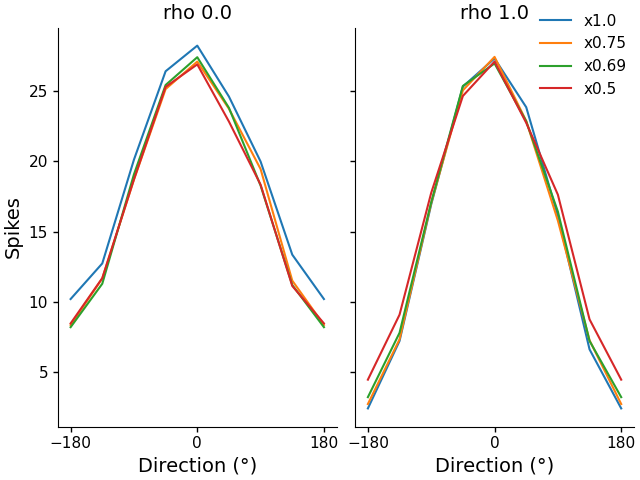

In [13]:
tuning_fig, tuning_ax = plt.subplots(1, len(rhos), sharey=True)
for i, (ax, rho) in enumerate(zip(tuning_ax, rhos)):
    ax.set_xlabel("Direction (°)", fontsize=14)
    ax.set_title("rho " + str(rho), fontsize=14)
    for step_lbl in step_lbls:
        lbl = ("x" + str(step_lbl)) if not i else None
        ax.plot(circ_180, wrap_circ(avg_spikes[step_lbl][rho][dir_sort]), label=lbl)
    ax.set_xticks([-180, 0, 180])
tuning_ax[0].set_ylabel("Spikes", fontsize=14)
tuning_fig.legend(frameon=False, fontsize=11)
clean_axes(tuning_ax)
tuning_fig.set_layout_engine("compressed")
for ext in exts:
    tuning_fig.savefig(os.path.join(fig_path, "contrast_tuning%s"  %(ext)), bbox_inches="tight")

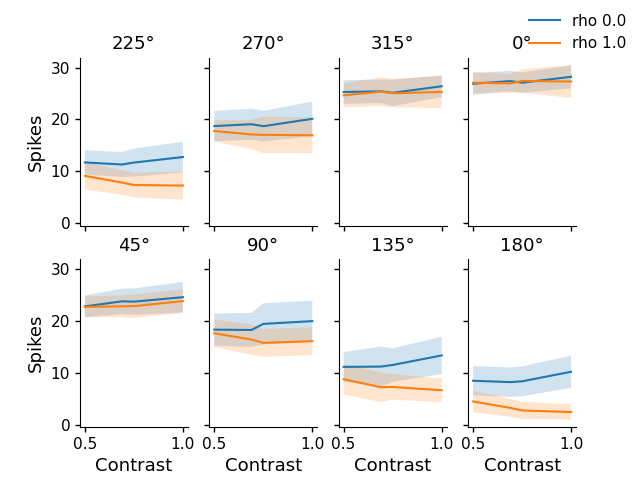

In [14]:
dir_grid_fig, dir_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_grid_ax:
    row[0].set_ylabel("Spikes", fontsize=13)
    for ax in row:
        for rho in rhos:
            spks = np.array([avg_spikes[step_lbl][rho][i] for step_lbl in step_lbls])
            stds = np.array([std_spikes[step_lbl][rho][i] for step_lbl in step_lbls])
            lbl = ("rho " + str(rho)) if not i else None
            ax.fill_between(step_lbls, spks + stds, spks - stds, alpha=0.2)
            ax.plot(step_lbls, spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_grid_ax.T:
    col[-1].set_xlabel("Contrast", fontsize=13)

# dir_grid_ax[0, 0].invert_xaxis()
# dir_grid_ax[0, 0].set_xscale("log")
dir_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(dir_grid_ax)
for ext in exts:
    dir_grid_fig.savefig(os.path.join(
        fig_path, "contrast_dir_spikes_grid%s" % (ext)), bbox_inches="tight")

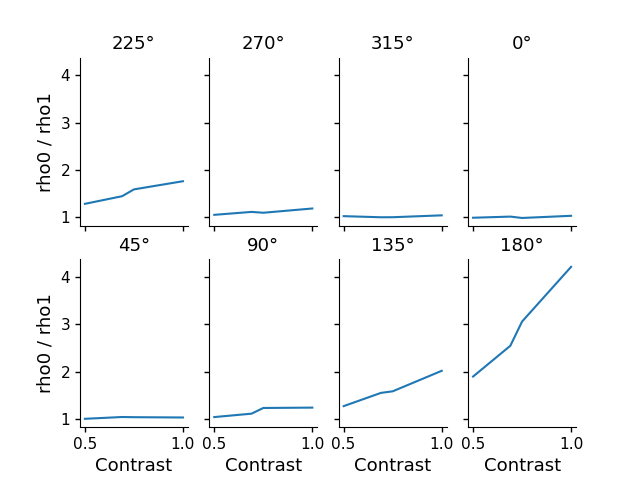

In [15]:
dir_mult_grid_fig, dir_mult_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_mult_grid_ax:
    row[0].set_ylabel("rho0 / rho1", fontsize=13)
    for ax in row:
        rho0_spks = np.array([avg_spikes[step_lbl][0.0][i] for step_lbl in step_lbls])
        rho1_spks = np.array([avg_spikes[step_lbl][1.0][i] for step_lbl in step_lbls])
        ax.plot(step_lbls, rho0_spks / rho1_spks)
        ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_mult_grid_ax.T:
    col[-1].set_xlabel("Contrast", fontsize=13)
        
clean_axes(dir_mult_grid_ax)
for ext in exts:
    dir_mult_grid_fig.savefig(os.path.join(
        fig_path, "contrast_dir_spikes_effect_of_rho_grid%s" % (ext)), bbox_inches="tight")

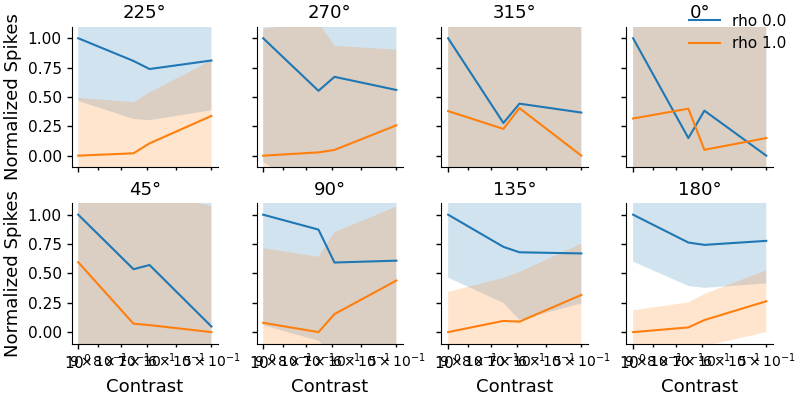

In [16]:
norm_dir_grid_fig, norm_dir_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(8, 4))

norm_dir_spikes, norm_dir_stds = [], []
for i in range(len(dir_labels)):
    spks = np.stack([[avg_spikes[step_lbl][rho][i] for step_lbl in step_lbls] for rho in rhos], axis=0)
    stds = np.stack([[std_spikes[step_lbl][rho][i] for step_lbl in step_lbls] for rho in rhos], axis=0)
    min_spks = np.min(spks)
    max_spks = np.max(spks)
    spks = (spks - min_spks) / (max_spks - min_spks)
    stds = stds / (max_spks - min_spks)
    norm_dir_spikes.append(spks)
    norm_dir_stds.append(stds)
norm_dir_spikes = np.stack(norm_dir_spikes, axis=0)
norm_dir_stds = np.stack(norm_dir_stds, axis=0)
    
i = 0
for row in norm_dir_grid_ax:
    row[0].set_ylabel("Normalized Spikes", fontsize=13)
    for ax in row:
        for j, rho in enumerate(rhos):
            lbl = ("rho " + str(rho)) if not i else None
            spks = norm_dir_spikes[i, j]
            stds = norm_dir_stds[i, j]
            ax.fill_between(step_lbls, spks + stds, spks - stds, alpha=0.2)
            ax.plot(step_lbls, spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in norm_dir_grid_ax.T:
    col[-1].set_xlabel("Contrast", fontsize=13)
        
norm_dir_grid_ax[0, 0].set_ylim(-0.1, 1.1)
norm_dir_grid_ax[0, 0].invert_xaxis()
norm_dir_grid_ax[0, 0].set_xscale("log")
norm_dir_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(norm_dir_grid_ax)
norm_dir_grid_fig.set_layout_engine("compressed")
for ext in exts:
    norm_dir_grid_fig.savefig(os.path.join(
        fig_path, "contrast_norm_dir_spikes_grid%s" % (ext)), bbox_inches="tight")

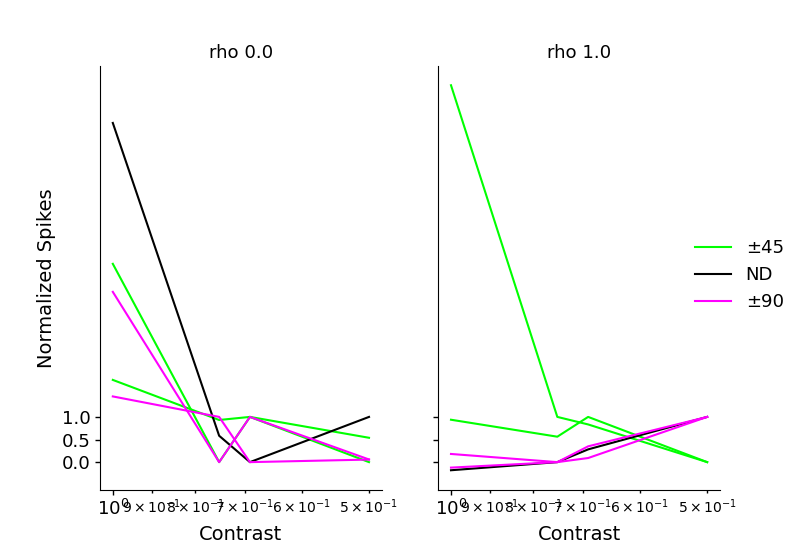

In [17]:
fctrs = step_lbls[:]
# fctrs = factors[4:]
norm_rho_dir_spikes, norm_rho_dir_stds = [], []
for i in range(len(dir_labels)):
    spks = np.stack([[avg_spikes[factor][rho][i] for factor in fctrs] for rho in rhos], axis=0)
    stds = np.stack([[std_spikes[factor][rho][i] for factor in fctrs] for rho in rhos], axis=0)
    # if gaba factor x0.0 is included, lines will not reach spiking=1 on the log plot
    min_spks = np.min(spks[:, 1:], axis=1, keepdims=True) 
    max_spks = np.max(spks[:, 1:], axis=1, keepdims=True)
    spks = (spks - min_spks) / (max_spks - min_spks)
    stds = stds / (max_spks - min_spks)
    norm_rho_dir_spikes.append(spks)
    norm_rho_dir_stds.append(stds)
norm_rho_dir_spikes = np.stack(norm_rho_dir_spikes, axis=0)
norm_rho_dir_stds = np.stack(norm_rho_dir_stds, axis=0)

log_titration_fig, log_titration_ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 5.5))
for r, ax in enumerate(log_titration_ax):
    ax.plot(fctrs, norm_rho_dir_spikes[2, r], label="±45" if r else None, c="lime")  # 45
    ax.plot(fctrs, norm_rho_dir_spikes[4, r], c="lime")  # 315
    # ax.fill_between(
    #     fctrs, 
    #     norm_rho_dir_spikes[7, r] + norm_rho_dir_stds[7, r],
    #     norm_rho_dir_spikes[7, r] - norm_rho_dir_stds[7, r],
    #     alpha=0.2, color="black"
    # )
    ax.plot(fctrs, norm_rho_dir_spikes[7, r], label="ND" if r else None, c="black")  # 180
    ax.plot(fctrs, norm_rho_dir_spikes[1, r], label="±90" if r else None, c="magenta")  # 270
    ax.plot(fctrs, norm_rho_dir_spikes[5, r], c="magenta")  # 90
    ax.set_title("rho %.1f" % rhos[r], fontsize=13)
    ax.set_xlabel("Contrast", fontsize=14)

log_titration_ax[0].set_yticks([0, 0.5, 1.0])
log_titration_ax[0].set_ylabel("Normalized Spikes", fontsize=14)
log_titration_ax[0].invert_xaxis()
log_titration_ax[0].set_xscale("log")
log_titration_fig.legend(frameon=False, loc="right", fontsize=13)
clean_axes(log_titration_ax, ticksize=13)
for ext in exts:
    log_titration_fig.savefig(os.path.join(
        fig_path, "log_contrast%s" % (ext)), bbox_inches="tight")

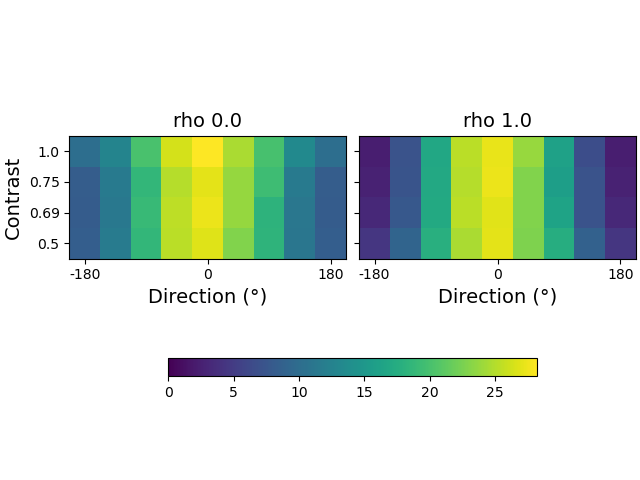

In [18]:
tuning_mat_fig, tuning_mat_ax = plt.subplots(1, 2, sharey=True)

avg_spike_mats = {
    rho: np.stack(
        [wrap_circ(avg_spikes[step_lbl][rho][dir_sort]) for step_lbl in step_lbls], axis=0)
    for rho in rhos
}
avg_max_spikes = np.max([m.max() for m in avg_spike_mats.values()])
avg_spike_imgs = {}

vmax = avg_max_spikes
# vmax = 20.0

for i, (ax, rho) in enumerate(zip(tuning_mat_ax, rhos)):
    ax.set_xlabel("Direction (°)", fontsize=14)
    ax.set_title("rho " + str(rho), fontsize=14)
    avg_spike_imgs[rho] = ax.imshow(avg_spike_mats[rho], vmin=0, vmax=vmax, cmap="viridis")
    ax.set_xticks([0, 4, 8])
    ax.set_xticklabels([-180, 0, 180])
    ax.set_yticks(range(len(step_lbls)))
    ax.set_yticklabels(step_lbls)
    
tuning_mat_ax[0].set_ylabel("Contrast", fontsize=14)
tuning_mat_fig.colorbar(
    avg_spike_imgs[rhos[-1]], ax=tuning_mat_ax, orientation="horizontal")
tuning_mat_fig.set_layout_engine("compressed")
for ext in exts:
    tuning_mat_fig.savefig(os.path.join(
        fig_path, "contrast_tuning_matrices%s" % (ext)), bbox_inches="tight")

In [19]:
close_button()